In [1]:
from fvhoe.initial_conditions import sinus
from fvhoe.solver import EulerSolver
from itertools import product
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
def l1err(x, y):
    return np.mean(np.abs(x - y))


def l2err(x, y):
    return np.sqrt(np.mean(np.square(x - y)))

In [3]:
def convergence_study(dims: str, Ns: list = [16, 32, 64, 128], ps: list = [0, 1, 2, 3]):
    """
    advect a smooth sine wave for one period and plot the error as a function of N and p
    args:
        dims (str) : some concatenation of "x", "y", or "z"
        Ns (iterable) : series of resolutions in increasing order
        ps (iterable) : series of polynomial degrees in increasing order
    """

    vx = 1 if "x" in dims else 0
    vy = 1 if "y" in dims else 0
    vz = 1 if "z" in dims else 0

    def f0(x, y, z):
        return sinus(x, y, z, dims=dims, vx=vx, vy=vy, vz=vz)

    # convergence study
    data = []
    for N, p in product(Ns, ps):
        print(f"{N=}, {p=}")

        nx = N if "x" in dims else 1
        ny = N if "y" in dims else 1
        nz = N if "z" in dims else 1

        solver = EulerSolver(
            f0,
            nx=nx,
            ny=ny,
            nz=nz,
            px=p if "x" in dims else 0,
            py=p if "y" in dims else 0,
            pz=p if "z" in dims else 0,
            riemann_solver="advection_upwind",
            progress_bar=False,
            cupy=True if 5 * nx * ny * nz > 65536 else False,
        )
        solver.rkorder(1)
        rho_error = l1err(solver.snapshots[0]["fv"].rho, solver.snapshots[1]["fv"].rho)
        data.append(dict(N=N, p=p, err=rho_error))
    df = pd.DataFrame(data)

    # plot
    fig, ax = plt.subplots()

    for p, dfp in df.groupby("p"):
        N0 = dfp.N.min()
        N1 = dfp.N.max()
        y0 = dfp.err.to_numpy()[0]
        ypred = y0 * ((N0 / N1) ** (p + 1))
        ax.plot([N0, N1], [y0, ypred], color="grey")
        ax.plot(dfp.N, dfp.err, label=f"{p=}", marker="o", mfc="none")

    ax.set_xlabel("$N$")
    ax.set_ylabel("L1 err")
    ax.set_xscale("log", base=2)
    ax.set_yscale("log")
    ax.legend()

N=16, p=0
N=16, p=1
N=16, p=2
N=16, p=3
N=32, p=0
N=32, p=1
N=32, p=2
N=32, p=3
N=64, p=0
N=64, p=1
N=64, p=2
N=64, p=3
N=128, p=0
N=128, p=1
N=128, p=2
N=128, p=3


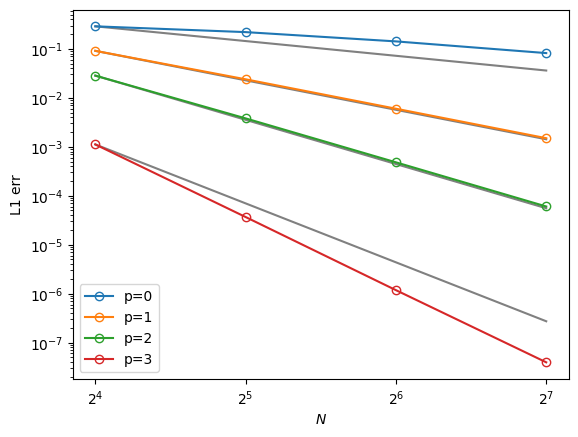

In [4]:
convergence_study("xyz")